In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision.utils as vutils
import matplotlib.pyplot as plt

from discriminator import Discriminator
from generator import Generator

from torch.utils.data import DataLoader, Dataset


from utils import *
import torchvision

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:


def visualize(dataloader, netG, netD, criterion, epoch, fixed_noise, device):
    real_batch = next(iter(dataloader))
    real_batch = real_batch[0].to(device)
    batch_size = real_batch.size(0)
    label = torch.full((batch_size,), 1.0, device=device)
    output = netD(real_batch).view(-1)
    errD_real = criterion(output, label)
    D_x = output.mean().item()

    fake = netG(fixed_noise)
    label.fill_(0.0)
    output = netD(fake.detach()).view(-1)
    errD_fake = criterion(output, label)
    D_G_z1 = output.mean().item()

    errD = errD_real + errD_fake

    label.fill_(1.0)
    output = netD(fake).view(-1)
    errG = criterion(output, label)
    D_G_z2 = output.mean().item()

    print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f'
          % (epoch, 100, 0, len(dataloader),
             errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

    

    fake = netG(fixed_noise)
    

    # Plot the fake images from the last epoch
    plt.figure(figsize=(8,8))
    plt.title("Fake Images")
    for row in range(8):
        for col in range(8):
            plt.subplot(8, 8, row*8+col+1)
            plt.axis("off")

            plt.imshow(fake[row*8+col].cpu().detach().numpy().transpose(1,2,0))
    plt.show()

    # Plot the real images from the last epoch
    plt.figure(figsize=(8,8))
    plt.title("Real Images")
    for row in range(8):
        for col in range(8):
            plt.subplot(8, 8, row*8+col+1)
            plt.axis("off")

            plt.imshow(real_batch[row*8+col].cpu().detach().numpy().transpose(1,2,0))
    plt.show()
    




In [5]:
IMG_SIZE = 128
img_channels = 3

modelG = Generator(IMG_SIZE, img_ch=img_channels)
modelD = Discriminator(img_channels=img_channels)

modelD = torch.nn.DataParallel(modelD)
modelG = torch.nn.DataParallel(modelG)


checkpointG = torch.load('/ssd_scratch/cvit/anirudhkaushik/checkpoints/bganG_checkpoint_latest.pt')
checkpointD = torch.load('/ssd_scratch/cvit/anirudhkaushik/checkpoints/bganD_checkpoint_latest.pt')
modelG.module.load_state_dict(checkpointG['model'])
modelD.module.load_state_dict(checkpointD['model'])

modelG = modelG.to(device)
modelD = modelD.to(device)


fixed_noise = torch.randn(64, 100, 1, 1, device=device)
data_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((IMG_SIZE, IMG_SIZE)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Lambda(lambda x: (x - x.min())/ (x.max() - x.min())),


])
train = torchvision.datasets.FGVCAircraft(root='/ssd_scratch/cvit/anirudhkaushik/datasets', split="train",  download=True, transform=data_transforms)
val = torchvision.datasets.FGVCAircraft(root='/ssd_scratch/cvit/anirudhkaushik/datasets', split="val",  download=True, transform=data_transforms)
test = torchvision.datasets.FGVCAircraft(root='/ssd_scratch/cvit/anirudhkaushik/datasets', split="test",  download=True, transform=data_transforms)

data_loader = DataLoader(torch.utils.data.ConcatDataset([train, val, test]), batch_size=64, shuffle=True)


# visualize


/tmp/ipykernel_18388/2278979177.py:37: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(8, 8, row*8+col+1)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] f

[0/100][0/157] Loss_D: 100.0029 Loss_G: 0.0000 D(x): 0.9972 D(G(z)): 1.0000 / 1.0000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

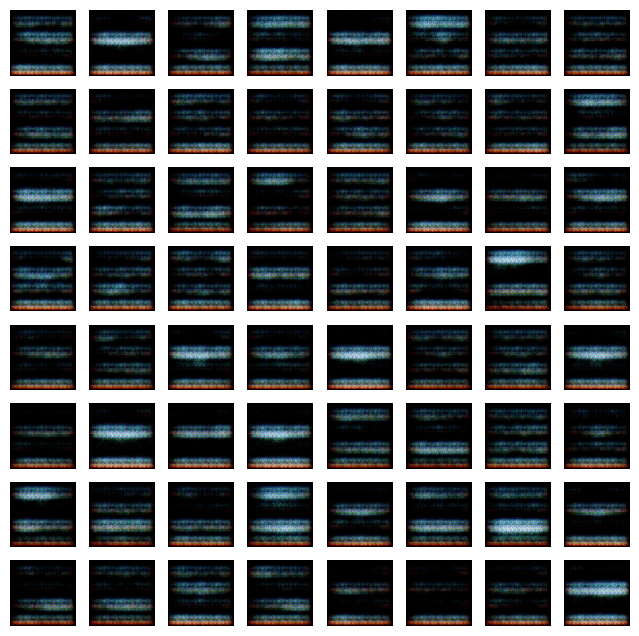

/tmp/ipykernel_18388/2278979177.py:48: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(8, 8, row*8+col+1)


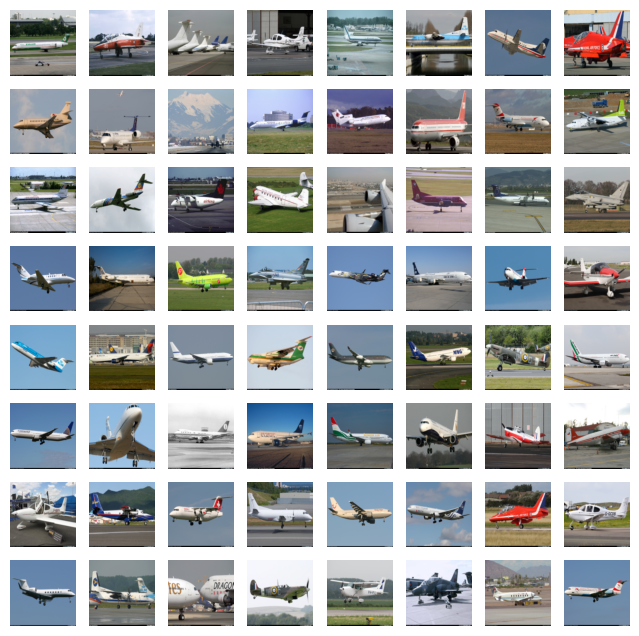

In [6]:
criterion = nn.BCELoss()
visualize(data_loader, modelG, modelD, criterion, 0, fixed_noise, device)